# Deep learning

**Tensore**

Un tensore è un array n-dimensionale. In Python la sua rappresentazione più semplice è una lista

In [ ]:
Tensor = list

**Alcune funzioni di utility per lavorare con i tensori definiti come qui sopra:**



*   Funzione per ottenere la forma (shape) di un tensore



In [ ]:
from typing import List

def shape(tensor):
    sizes = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return sizes



*   Per capire se il tensore è monodimensionale



In [ ]:
def is_1d(tensor):
    """
    If tensor[0] is a list, it's a higher-order tensor.
    Otherwise, tensor is 1-dimensonal (that is, a vector).
    """
    return not isinstance(tensor[0], list)

* Somma di tutti i valori in un tensore

In [ ]:
def tensor_sum(tensor: Tensor) -> float:
    """Sums up all the values in the tensor"""
    if is_1d(tensor):
        return sum(tensor)  # just a list of floats, use Python sum
    else:
        return sum(tensor_sum(tensor_i)      # Call tensor_sum on each row
                   for tensor_i in tensor)   # and sum up those results.

* Applicazione di una funzione a tutti gli elementi di un tensore

In [ ]:
from typing import Callable

def tensor_apply(f: Callable[[float], float], tensor):
    """Applies f elementwise"""
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]

* Tensore di tutti zeri con la stessa forma di quello passato in input

In [ ]:
def zeros_like(tensor):
    return tensor_apply(lambda _: 0.0, tensor)

* Applica la funzione passata in input agli elementi corrispondenti dei 2 tensori. I tensori devono avere la stessa forma.

In [ ]:
def tensor_combine(f: Callable[[float, float], float], t1, t2) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
                for t1_i, t2_i in zip(t1, t2)]

**Layer**

* Per costruire reti neurali, occorre definire i layer, ovvero i vari strati che andranno a costruire la rete. Un layer deve poter applicare funzioni agli input e deve poter retropropagare i gradienti (backpropagation).

In [ ]:
from typing import Iterable, Tuple

class Layer:
    """
    Our neural networks will be composed of Layers, each of which
    knows how to do some computation on its inputs in the "forward"
    direction and propagate gradients in the "backward" direction.
    """
    def forward(self, input):
        """
        Note the lack of types. We're not going to be prescriptive
        about what kinds of inputs layers can take and what kinds
        of outputs they can return.
        """
        raise NotImplementedError

    def backward(self, gradient):
        """
        Similarly, we're not going to be prescriptive about what the
        gradient looks like. It's up to you the user to make sure
        that you're doing things sensibly.
        """
        raise NotImplementedError

    def params(self) -> Iterable[Tensor]:
        """
        Returns the parameters of this layer. The default implementation
        returns nothing, so that if you have a layer with no parameters
        you don't have to implement this.
        """
        return ()

    def grads(self) -> Iterable[Tensor]:
        """
        Returns the gradients, in the same order as params()
        """
        return ()

* Layer sigmoideo

Layer che applica agli input la funzione sigmoidea $f(t)=1/(1+e^-t)$.

In [ ]:
import math

def sigmoid(t):
  return 1/(1+math.exp(-t))

class Sigmoid(Layer):
    def forward(self, input: Tensor):
        """
        Apply sigmoid to each element of the input tensor,
        and save the results to use in backpropagation.
        """
        self.sigmoids = tensor_apply(sigmoid, input)
        return self.sigmoids

    def backward(self, gradient: Tensor):
        return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad,
                              self.sigmoids,
                              gradient)

* Layer lineare

Questo layer applica la funzione `dot(weights, inputs)` (*w_1 x i_1 + ... + w_n x i_n*). I parametri del layer sono inizializzati casualmente e verranno migliorati con la discesa del gradiente.



*   Tensori con parametri casuali:



In [ ]:
import random
from probability import inverse_normal_cdf

def random_uniform(*dims: int) -> Tensor:
    if len(dims) == 1:
        return [random.random() for _ in range(dims[0])]
    else:
        return [random_uniform(*dims[1:]) for _ in range(dims[0])]

def random_normal(*dims: int,
                  mean: float = 0.0,
                  variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
                for _ in range(dims[0])]
                
def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unknown init: {init}")



*   Implementazione layer lineare:



In [ ]:
from linear_algebra import dot # w_1 x i_1 + ... + w_n x i_n

class Linear(Layer):
    def __init__(self, input_dim: int, output_dim: int, init: str = 'xavier') -> None:
        """
        A layer of output_dim neurons, each with input_dim weights
        (and a bias).
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] is the weights for the o-th neuron
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.b[o] is the bias term for the o-th neuron
        self.b = random_tensor(output_dim, init=init)

    def forward(self, input: Tensor) -> Tensor:
        # Save the input to use in the backward pass.
        self.input = input

        # Return the vector of neuron outputs.
        return [dot(input, self.w[o]) + self.b[o]
                for o in range(self.output_dim)]

    def backward(self, gradient: Tensor) -> Tensor:
        # Each b[o] gets added to output[o], which means
        # the gradient of b is the same as the output gradient.
        self.b_grad = gradient

        # Each w[o][i] multiplies input[i] and gets added to output[o].
        # So its gradient is input[i] * gradient[o].
        self.w_grad = [[self.input[i] * gradient[o]
                        for i in range(self.input_dim)]
                       for o in range(self.output_dim)]

        # Each input[i] multiplies every w[o][i] and gets added to every
        # output[o]. So its gradient is the sum of w[o][i] * gradient[o]
        # across all the outputs.
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]

**Sequenza**

Definiti i layer, definiamo una struttura che contenga una sequenza di layer, ovvero la rete neurale.

In [ ]:
from typing import List

class Sequential(Layer):
    """
    A layer consisting of a sequence of other layers.
    It's up to you to make sure that the output of each layer
    makes sense as the input to the next layer.
    """
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers

    def forward(self, input):
        """Just forward the input through the layers in order."""
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, gradient):
        """Just backpropagate the gradient through the layers in reverse."""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def params(self) -> Iterable[Tensor]:
        """Just return the params from each layer."""
        return (param for layer in self.layers for param in layer.params())

    def grads(self) -> Iterable[Tensor]:
        """Just return the grads from each layer."""
        return (grad for layer in self.layers for grad in layer.grads())

**Errore e ottimizzazione**

Viene ora introdotta una classe generica *Loss* per implementare diverse astrazioni del calcolo dell'errore e del gradiente. La funzione *Loss* sarà quella da minimizzare

In [ ]:
class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """How good are our predictions? (Larger numbers are worse.)"""
        raise NotImplementedError

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """How does the loss change as the predictions change?"""
        raise NotImplementedError

* Prima implementazione, l'errore è la somma dei quadrati degli errori

In [ ]:
class SSE(Loss):
    """Loss function that computes the sum of the squared errors."""
    def loss(self, predicted, actual):
        # Compute the tensor of squared differences
        squared_errors = tensor_combine(
            lambda predicted, actual: (predicted - actual) ** 2,
            predicted,
            actual)

        # And just add them up
        return tensor_sum(squared_errors)

    def gradient(self, predicted, actual):
        return tensor_combine(
            lambda predicted, actual: 2 * (predicted - actual),
            predicted,
            actual)



*   Introduzione di un ulteriore classe astratta: *Optimizer*. Gli optimizer serviranno ad aggiornare i parametri con nuovi valori, come quelli calcolati con la discesa del gradiente



In [ ]:
class Optimizer:
    """
    An optimizer updates the weights of a layer (in place) using information
    known by either the layer or the optimizer (or by both).
    """
    def step(self, layer: Layer) -> None:
        raise NotImplementedError



*   La discesa del gradiente è il primo *Optimizer* implementato


In [ ]:
class GradientDescent(Optimizer):
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr = learning_rate

    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # Update param using a gradient step
            param[:] = tensor_combine(
                lambda param, grad: param - grad * self.lr,
                param,
                grad)




*   *Optimizer Momentum*. A differenza della discesa del gradiente, questo optimizer non usa solo l'ultimo step del gradiente, ma mantiene una media dei gradienti precedenti che viene aggiornata ad ogni iterazione col nuovo step.


In [ ]:
class Momentum(Optimizer):
    def __init__(self,
                 learning_rate: float,
                 momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []  # running average

    def step(self, layer: Layer) -> None:
        # If we have no previous updates, start with all zeros.
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]

        for update, param, grad in zip(self.updates,
                                       layer.params(),
                                       layer.grads()):
            # Apply momentum
            update[:] = tensor_combine(
                lambda u, g: self.mo * u + (1 - self.mo) * g,
                update,
                grad)

            # Then take a gradient step
            param[:] = tensor_combine(
                lambda p, u: p - self.lr * u,
                param,
                update)



**Test di una rete neurale: XOR gate**


* Definiti ora tutti gli elementi che vanno a comporre una rete neurale (neuroni, layer, sequenze, optimizer, funzioni d'errore), è possibile crearne una ed addestrarla per funzionare da porta XOR.




*   Dati di addestramento (training set). In X le variabili in input, in y gli output corretti:



In [ ]:
xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
ys = [[0.], [1.], [1.], [0.]]

* Addestramento rete

In [ ]:
random.seed(0)
    
net = Sequential([
      Linear(input_dim=2, output_dim=2),
      Sigmoid(),
      Linear(input_dim=2, output_dim=1)
  ])    
    
import tqdm
    
optimizer = GradientDescent(learning_rate=0.1)
loss = SSE()
    
with tqdm.trange(3000) as t:
      for epoch in t:
           epoch_loss = 0.0
    
      for x, y in zip(xs, ys):
          predicted = net.forward(x)
          epoch_loss += loss.loss(predicted, y)
          gradient = loss.gradient(predicted, y)
          net.backward(gradient) 
          optimizer.step(net)
    
t.set_description(f"xor loss {epoch_loss:.3f}")

100%|██████████| 3000/3000 [00:00<00:00, 936089.27it/s]


**Altre funzioni di attivazione**

La sigmoidea non è l'unica funzione di attivazione che si utilizza, e spesso gliene si preferiscono altre in quanto $sigmoid(0) = 1/2$; vale a dire che se la somma degli input di un neurone è 0, la funzione fornisce in output un valore positivo. Una funzione molto utilizzata $tanh$, la tangente iperbolica

*   Funzione tangente iperbolica

$tanh(x)=sinh(x)/cosh(x)$

$d/dx(tanh(x))=1-tanh(x)^2$

Ha range -1, 1 e forma sigmoidale, ma per input 0 ha output 0.


* Implementazione in python della funzione e implementazione di un layer che la utilizza come attivazione:






In [ ]:
import math

def tanh(x: float) -> float:
    # If x is very large or very small, tanh is (essentially) 1 or -1.
    # We check for this because e.g. math.exp(1000) raises an error.
    if x < -100:  return -1
    elif x > 100: return 1

    em2x = math.exp(-2 * x)
    return (1 - em2x) / (1 + em2x)

class Tanh(Layer):
    def forward(self, input: Tensor) -> Tensor:
        # Save tanh output to use in backward pass.
        self.tanh = tensor_apply(tanh, input)
        return self.tanh

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(
            lambda tanh, grad: (1 - tanh ** 2) * grad,
            self.tanh,
            gradient)



*   Rectified Linear Unit (ReLU)

$ReLU(x)=x^+=max(0, x)$
Un'altra funzione spesso utilizzata è ReLU. L'output è 0 per input negativi e l'identità per input positivi.

In [ ]:
class Relu(Layer):
    def forward(self, input: Tensor) -> Tensor:
        self.input = input
        return tensor_apply(lambda x: max(x, 0), input)

    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda x, grad: grad if x > 0 else 0,
                              self.input,
                              gradient)

**Test di rete neurale: FizzBuzz**

Il problema da risolvere, chiamato *Fizzbuzz*, è il seguente:

 *Stampare i numeri da 1 a 100, se il numero è divisibile per 3, stampare "fizz" invece del numero. Se il numero è divisibile per 5, stampare "buzz" al posto del numero. Se il numero è divisibile per 15, stampare "fizzbuzz" al posto del numero.*



*   Encoding dell'output in un vettore di 4 numeri binari

In [ ]:
def fizz_buzz_encode(x):
    if x % 15 == 0:
        return [0, 0, 0, 1]
    elif x % 5 == 0:
        return [0, 0, 1, 0]
    elif x % 3 == 0:
        return [0, 1, 0, 0]
    else:
        return [1, 0, 0, 0]

* Encoding da decimale a binario

In [ ]:
def binary_encode(x):
    binary: List[float] = []

    for i in range(10):
        binary.append(x % 2)
        x = x // 2

    return binary


* Funzione che ritorna l'indice del valore più grande

In [ ]:
def argmax(xs: list) -> int:
    """Returns the index of the largest value"""
    return max(range(len(xs)), key=lambda i: xs[i])

* Training set

In [ ]:
xs = [binary_encode(n) for n in range(101, 1024)]
ys = [fizz_buzz_encode(n) for n in range(101, 1024)]

* Creazione rete neurale

In [ ]:
random.seed(0)
    
NUM_HIDDEN = 25

net = Sequential([
   Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
   Tanh(),
   Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform'),
   Sigmoid()
  ])

* Funzione per valutare la precisione della rete

In [ ]:
def fizzbuzz_accuracy(low, hi, net):
    num_correct = 0
    for n in range(low, hi):
        x = binary_encode(n)
        predicted = argmax(net.forward(x))
        actual = argmax(fizz_buzz_encode(n))
        if predicted == actual:
              num_correct += 1
    
    return num_correct / (hi - low)

* Training rete neurale

In [ ]:
optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SSE()
    
with tqdm.trange(1000) as t:
    for epoch in t:
        epoch_loss = 0.0
    
        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)
    
            optimizer.step(net)
    
        accuracy = fizzbuzz_accuracy(101, 1024, net)
        t.set_description(f"fb loss: {epoch_loss:.2f} acc: {accuracy:.2f}")
    
# Now check results on the test set
print("test results", fizzbuzz_accuracy(1, 101, net))

fb loss: 64.54 acc: 0.95: 100%|██████████| 1000/1000 [12:12<00:00,  1.37it/s]

test results 0.9




*   Con mille iterazioni di training, la precisione raggiunta dal modello è del 90%



**Softmax**

Al posto del layer sigmoidale finale, si può usare la funziona softmax, che converte il vettore di numeri reali in un vettore di probabilità. Per farlo convertiamo tutti i numeri nel vettore x in positivo usando $e^x$, e poi dividiamo ognuno dei numeri ottenuti per la somma, ottenendo la probabilità di quell'elemento del vettore.

In [ ]:
def softmax(tensor: Tensor) -> Tensor:
    """Softmax along the last dimension"""
    if is_1d(tensor):
        # Subtract largest value for numerical stabilitity.
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]

        sum_of_exps = sum(exps)                 # This is the total "weight".
        return [exp_i / sum_of_exps             # Probability is the fraction
                for exp_i in exps]              # of the total weight.
    else:
        return [softmax(tensor_i) for tensor_i in tensor]


**Funzione di errore entropia incrociata**

In [ ]:
class SoftmaxCrossEntropy(Loss):
    """
    This is the negative-log-likelihood of the observed values, given the
    neural net model. So if we choose weights to minimize it, our model will
    be maximizing the likelihood of the observed data.
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Apply softmax to get probabilities
        probabilities = softmax(predicted)

        # This will be log p_i for the actual class i and 0 for the other
        # classes. We add a tiny amount to p to avoid taking log(0).
        likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act,
                                     probabilities,
                                     actual)

        # And then we just sum up the negatives.
        return -tensor_sum(likelihoods)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        probabilities = softmax(predicted)

        # Isn't this a pleasant equation?
        return tensor_combine(lambda p, actual: p - actual,
                              probabilities,
                              actual)

In [ ]:
net = Sequential([
        Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
        Tanh(),
        Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform')
        # No final sigmoid layer now
    ])

In [ ]:
optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SoftmaxCrossEntropy()
    
with tqdm.trange(1000) as t:
    for epoch in t:
        epoch_loss = 0.0
    
        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)
    
            optimizer.step(net)
    
        accuracy = fizzbuzz_accuracy(101, 1024, net)
        t.set_description(f"fb loss: {epoch_loss:.2f} acc: {accuracy:.2f}")
    
# Now check results on the test set
print("test results", fizzbuzz_accuracy(1, 101, net))

fb loss: 5.03 acc: 1.00: 100%|██████████| 1000/1000 [12:09<00:00,  1.37it/s]

test results 0.98




*   Precisione del 98%



**Dropout**

I modelli di reti neurali tendono all'overfitting. Per mitigare questo problema si utilizza un metodo chiamato *dropout*. Durante il training, alcuni neuroni scelti casualmente vengono spenti per fare in modo che la rete nel suo complesso non dipenda in maniera eccessiva dai singoli neuroni.

Per la fase valutazione si vogliono invece usare tutti i neuroni, quindi il layer di dropout dovrà sapere in quale fase ci si trova.

Inoltre, visto che il layer di dropout fornisce in output solo una parte del suo input (a causa dei neuroni spenti), in fase di valutazione ridurre nella stessa proporzione gli output.

In [ ]:
class Dropout(Layer):
    def __init__(self, p: float) -> None:
        self.p = p
        self.train = True

    def forward(self, input: Tensor) -> Tensor:
        if self.train:
            # Create a mask of 0s and 1s shaped like the input
            # using the specified probability.
            self.mask = tensor_apply(
                lambda _: 0 if random.random() < self.p else 1,
                input)
            # Multiply by the mask to dropout inputs.
            return tensor_combine(operator.mul, input, self.mask)
        else:
            # During evaluation just scale down the outputs uniformly.
            return tensor_apply(lambda x: x * (1 - self.p), input)

    def backward(self, gradient: Tensor) -> Tensor:
        if self.train:
            # Only propagate the gradients where mask == 1
            return tensor_combine(operator.mul, gradient, self.mask)
        else:
            raise RuntimeError("don't call backward when not in train mode")

# Caso studio: MNIST


In [ ]:
!pip install mnist
import mnist

mnist.temporary_dir = lambda: "/tmp"

* MNIST è un dataset di cifre scritte a mano, l'obiettivo è costruire una rete neurale come visto in precedenza ed addestrarla a riconoscere quest cifre.



In [ ]:
train_images = mnist.train_images().tolist()
shape(train_images)

[60000, 28, 28]

In [ ]:
train_labels = mnist.train_labels().tolist()
shape(train_labels)

[60000]

* Il set di training scaricato è di default un array NumPy, visto che in questo caso l'approccio è "from scratch", viene convertito a lista con `tolist()`.



*   Visualizzazione di 25 delle cifre


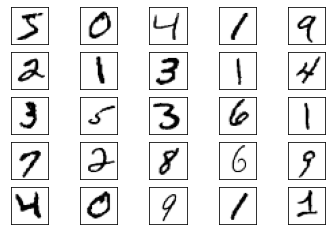

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 5)
    
for i in range(5):
    for j in range(5):
        # Plot each image in black and white and hide the axes.
        ax[i][j].imshow(train_images[5 * i + j], cmap='Greys')
        ax[i][j].xaxis.set_visible(False)
        ax[i][j].yaxis.set_visible(False)

* Download del validation set

In [ ]:
test_images = mnist.test_images().tolist()
test_labels = mnist.test_labels().tolist()

* Il layer lineare come definito prima accetta solo input monodimensionali, quindi bisognerà ridurre la dimensionionalità delle immagini come una operazione di flattening. Ad ogni immagine, viene poi sottratto il valore medio e il tutto viene diviso per 256, per avere dei valori compresi tra 0 e 1.

In [ ]:
# Compute the average pixel value
avg = tensor_sum(train_images) / 60000 / 28 / 28
    
# Rescale, and flatten
train_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                  for image in train_images]
test_images = [[(pixel - avg) / 256 for row in image for pixel in row]
                  for image in test_images]

* Occorre anche una funzione di one-hot-encoding, per effettuare un encoding sulle etichette, in quanto abbiamo 10 output

In [ ]:
def one_hot_encode(i, num_labels = 10):
    return [1.0 if j == i else 0.0 for j in range(num_labels)]
    
train_labels = [one_hot_encode(label) for label in train_labels]
test_labels = [one_hot_encode(label) for label in test_labels]

* Adesso le etichette sono in forma vettoriale

In [ ]:
train_labels[:5]

[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]

* Viene adesso definita una funzione `loop`. Questo loop verrà utilizzato per l'addestramento, qualora venga passato un optimizer, o per la validazione, in caso non venga passato un optimizer

In [ ]:
def loop(model: Layer,
             images: List[Tensor],
             labels: List[Tensor],
             loss: Loss,
             optimizer: Optimizer = None) -> None:
        correct = 0         # Track number of correct predictions.
        total_loss = 0.0    # Track total loss.
    
        with tqdm.trange(len(images)) as t:
            for i in t:
                predicted = model.forward(images[i])             # Predict.
                if argmax(predicted) == argmax(labels[i]):       # Check for
                    correct += 1                                 # correctness.
                total_loss += loss.loss(predicted, labels[i])    # Compute loss.
    
                # If we're training, backpropagate gradient and update weights.
                if optimizer is not None:
                    gradient = loss.gradient(predicted, labels[i])
                    model.backward(gradient)
                    optimizer.step(model)
    
                # And update our metrics in the progress bar.
                avg_loss = total_loss / (i + 1)
                acc = correct / (i + 1)
                t.set_description(f"mnist loss: {avg_loss:.3f} acc: {acc:.3f}")

1. **Test di un modello semplice di regressione logistica**



*   Definito il loop, lo si può utilizzare per addestrare un semplice modello di regressione logistica. Non è altro che un layer lineare con gli output che vengono poi passato alla funzione softmax che fornisce 10 output fra 0 e 1.


In [ ]:
# Logistic regression is just a linear layer followed by softmax
model = Linear(784, 10)
loss = SoftmaxCrossEntropy()
    
# This optimizer seems to work
optimizer = Momentum(learning_rate=0.01, momentum=0.99)
    
# Train on the training data
loop(model, train_images, train_labels, loss, optimizer)
    
# Test on the test data (no optimizer means just evaluate)
loop(model, test_images, test_labels, loss)

mnist loss: 0.361 acc: 0.891: 100%|██████████| 10000/10000 [00:58<00:00, 170.79it/s]


* Questo modello ha una precisione dell'89% a fronte di 16 minuti impiegati per l'addestramento

2. **Test di un modello con rete neurale *profonda***

* Questa volta il modello utilizzato ha due hidden layer, entrambi con $tanh$ come funzione di attivazione. Si fa anche utuilizzo di dropout con probabilità 0.1 in entrambi i layer.

In [ ]:
random.seed(0)

dropout1 = Dropout(0.1)
dropout2 = Dropout(0.1)
    
model = Sequential([
    Linear(784, 30),  # Hidden layer 1: size 30
    dropout1,
    Tanh(),
    Linear(30, 10),   # Hidden layer 2: size 10
    dropout2,
    Tanh(),
    Linear(10, 10)    # Output layer: size 10
    ])
    
    
# Training the deep model for MNIST
    
optimizer = Momentum(learning_rate=0.01, momentum=0.99)
loss = SoftmaxCrossEntropy()
    
# Enable dropout and train (takes > 20 minutes on my laptop!)
dropout1.train = dropout2.train = True
loop(model, train_images, train_labels, loss, optimizer)
    
# Disable dropout and evaluate
dropout1.train = dropout2.train = False
loop(model, test_images, test_labels, loss)

# Test di un modello con libreria Keras

Dopo aver implementato due reti neurali "from scratch", provo ad implementarne una con la libreria Keras per risolvere lo stesso problema delle cifre scritte a mano.

La rete neurale è composta da due strati *dense* da 30 e 10 neuroni con attivazione *ReLU* e layer di output con attivazione *softmax*, come funzione loss si utilizza *crossentropy*, che è simile a quella implementata precedentemente ed è indicata quando le etichette hanno una rappresentazione *one-hot*, come in questo caso.

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential([
    Dense(30, activation="relu", input_shape=(784,)),
    Dense(10, activation="relu"),
    Dense(10, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
fit_history = model.fit(train_images, train_labels, epochs=10)


Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8455 - accuracy: 0.7234
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2136 - accuracy: 0.9377
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1645 - accuracy: 0.9504
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1360 - accuracy: 0.9601
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1188 - accuracy: 0.9647
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1070 - accuracy: 0.9675
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0985 - accuracy: 0.9690
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0916 - accuracy: 0.9709
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0844 - accuracy: 0.9739
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.082

In [ ]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 1ms/step - loss: 0.1121 - accuracy: 0.9672


[0.11205915361642838, 0.967199981212616]

* La rete neurale creata con libreria Keras ha una precisione del 97% e ha richiesto meno di 3 minuti per l'addestramento sullo stesso dataset: un risultato nettamente migliore rispetto alle reti neurali *from scratch* implementate sopra.
